In [ ]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import random as random
import copy as copy
from sklearn.metrics import mean_squared_error
import math

In [ ]:
data = yf.download('MSFT', '2013-01-01', '2023-01-01')

[*********************100%***********************]  1 of 1 completed


In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,27.250000,27.730000,27.150000,27.620001,22.668234,52899300
2013-01-03,27.629999,27.650000,27.160000,27.250000,22.364563,48294400
2013-01-04,27.270000,27.340000,26.730000,26.740000,21.945999,52521100
2013-01-07,26.770000,26.879999,26.639999,26.690001,21.904959,37110400
2013-01-08,26.750000,26.790001,26.459999,26.549999,21.790064,44703100


In [ ]:
def normalize_dataset(inputs, outputs):
  normalized_inputs = []

  mins = [np.min(inputs[:, col_idx]) for col_idx in range(inputs.shape[1])]
  maxs = [np.max(inputs[:, col_idx]) for col_idx in range(inputs.shape[1])]

  for vector in inputs:
    normalized_vector = []
    for col_idx in range(vector.shape[0]):
      normalized_vector.append((vector[col_idx] - mins[col_idx]) / (maxs[col_idx] - mins[col_idx]))
    normalized_inputs.append(normalized_vector)

  min_output = np.min(outputs)
  max_output = np.max(outputs)

  normalized_outputs = [(x - min_output) / (max_output - min_output) for x in outputs]

  return np.array(normalized_inputs), np.array(normalized_outputs)


def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [ ]:
# function to modify the dataset using sliding window
# takes the last 'window_size' days' features and concatenates them horizontally to get n * window_size size input vector
# this is used and input to predict the closing price for the current day
def dataset_preparation(window_size = 1, train_test_split_year = 2020): # assumes the default window size to be 1

    # preparing the training dataset
    filt = data.index.year <= train_test_split_year
    train_df = data.loc[filt]

    X_train = []
    y_train = []

    # mins = [1e7 for i in range(6)]
    # maxs = [0 for i in range(6)]

    for i in range(window_size, len(train_df.values)):
        feature_set = []

        for j in range(i - 1, i - window_size, -1):
            feature_set.append(train_df.values[j][3])

        X_train.append(feature_set[::-1])
        y_train.append(train_df.iloc[i, 3]) # closing price

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_train, y_train = normalize_dataset(X_train, y_train)

    # preparing the testing dataset
    test_df = data.loc[~filt]

    X_test = []
    y_test = []

    for i in range(window_size, len(test_df.values)):
        feature_set = []
        for j in range(i - 1, i - window_size, -1):
            feature_set.append(test_df.values[j][3])
        X_test.append(feature_set[::-1])
        y_test.append(test_df.iloc[i, 3]) # closing price

    # converting lists to ndarrays

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    X_test, y_test = normalize_dataset(X_test, y_test)

    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    # reshaping the training and testing inputs for RNN variants
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = dataset_preparation(window_size = 8, train_test_split_year = 2020)

(2007, 7) (495, 7) (2007,) (495,)


In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# print(X_train[0:5])

(2007, 7, 1) (495, 7, 1) (2007,) (495,)


In [ ]:
# util functions

def get_predictions(model, inputs):
    predictions = model.predict(inputs)
    predictions = predictions.reshape(predictions.size)
    return predictions

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_squared_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) ** 2)

def plot_predictions(original, predicted, title = 'true values vs predicted values'):
    original_data = original
    predicted_data = predicted

    plt.figure()
    plt.plot(original_data, label='Original Data')
    plt.plot(predicted_data, label='Predicted Data')

    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title(title)
    plt.grid(True)
    plt.legend()

    plt.show()

In [ ]:
model = keras.Sequential()
model.add(layers.Bidirectional(layers.LSTM(120, input_shape = (7, 1))))
model.add(layers.Dense(1, activation = 'sigmoid'))
# model.summary()

In [ ]:
# training the model with backpropagation

model.compile(loss = 'mean_absolute_error', optimizer = 'adam')
model.fit(X_train, y_train, epochs = 100)

Epoch 1/100
63/63 [==============================] - 5s 7ms/step - loss: 0.1108
Epoch 2/100
63/63 [==============================] - 0s 7ms/step - loss: 0.0231
Epoch 3/100
63/63 [==============================] - 0s 8ms/step - loss: 0.0237
Epoch 4/100
63/63 [==============================] - 0s 7ms/step - loss: 0.0230
Epoch 5/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0217
Epoch 6/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0165
Epoch 7/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0094
Epoch 8/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 9/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0094
Epoch 10/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0092
Epoch 11/100
63/63 [==============================] - 0s 5ms/step - loss: 0.0103
Epoch 12/100
63/63 [==============================] - 0s 6ms/step - loss: 0.0094
Epoch 13/100
63/63 [=================

In [ ]:
lower_bound = 1
upper_bound = 1
for layer in model.layers:
        weights = layer.get_weights()
        for w in weights:
            lower_bound = min(lower_bound, np.min(w))
            upper_bound = max(upper_bound, np.max(w))

print(lower_bound, upper_bound)

-1.0120229 1.0990343


16/16 [==============================] - 0s 3ms/step


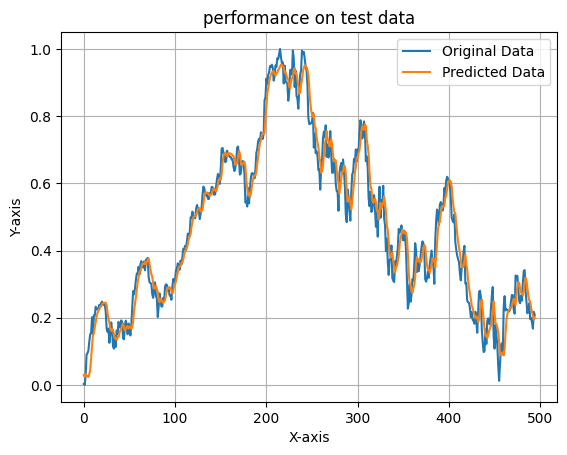

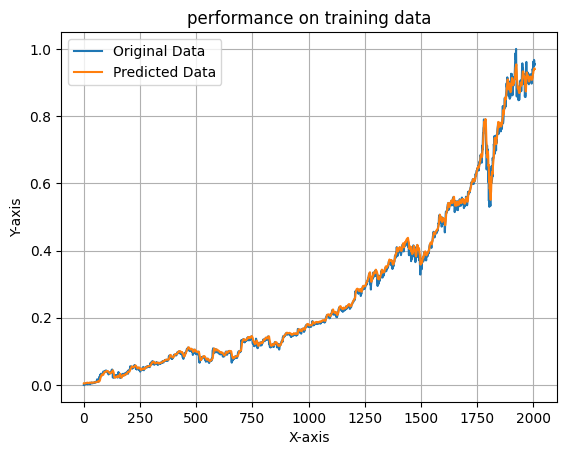

In [ ]:
train_predictions = get_predictions(model, X_train)
test_predictions = get_predictions(model, X_test)
plot_predictions(y_test, test_predictions, 'performance on test data')
plot_predictions(y_train, train_predictions, 'performance on training data')


In [ ]:
LSTM_MSE = mean_squared_error(y_test, test_predictions)
LSTM_MAE = mean_absolute_error(y_test, test_predictions)
LSTM_RMSE = math.sqrt(LSTM_MSE)
LSTM_SMAPE = smape(y_test, test_predictions)
LSTM_MSE_T = mean_squared_error(y_train, train_predictions)
LSTM_MAE_T = mean_absolute_error(y_train, train_predictions)
LSTM_RMSE_T = math.sqrt(LSTM_MSE)
LSTM_SMAPE_T = smape(y_train, train_predictions)
print('Training MAE - ', LSTM_MAE)
print('Testing MAE - ', LSTM_MAE_T)

Training MAE -  0.037059001273862247
Testing MAE -  0.006672235445279217


In [ ]:
# # arr = list(np.zeros(100000000000))
# # Manually update the weights
def update_weights(position):
    idx = 0
    for layer in model.layers:
        weights = layer.get_weights()
        # new_weights = [np.zeros(w.shape) for w in weights]
        new_weights = []
        for w in weights:
            tmp_arr = position[idx]
            idx = idx + 1
            tmp_arr = list(np.reshape(np.array(tmp_arr),w.shape))
            new_weights.append(np.array(tmp_arr, dtype='f'))
        # print(new_weights)
        layer.set_weights(new_weights)
        # for w in weights:
        #     print(w.shape)


def get_weights():
    new_weights = []
    for layer in model.layers:
        weights = layer.get_weights()
        # new_weights = [np.zeros(w.shape) for w in weights]
        for w in weights:
            new_weights.append(w.flatten())
    return new_weights


def dim_list():
    dim_list = []
    for layer in model.layers:
        weights = layer.get_weights()
        # new_weights = [np.zeros(w.shape) for w in weights]
        new_weights = []
        for w in weights:
            # print(w.shape)
            size = 1
            for sz in w.shape:
               size = size * sz
            dim_list.append(size)
    return dim_list


def cost_function(position):
    idx = 0
    for layer in model.layers:
        weights = layer.get_weights()
        # new_weights = [np.zeros(w.shape) for w in weights]
        new_weights = []
        for w in weights:
            tmp_arr = position[idx]
            idx = idx + 1
            tmp_arr = list(np.reshape(np.array(tmp_arr),w.shape))
            new_weights.append(np.array(tmp_arr, dtype='f'))
        layer.set_weights(new_weights)
    y_pred = get_predictions(model, X_train);
    mae = mean_absolute_error(y_pred, y_train)
    return mae


# Update the weights manually
# update_weights(model)
# print(dim_list(model))



In [ ]:
class wolf:
  def __init__(self, dim_list, minx, maxx, seed):
    self.rnd = random.Random(seed)
    self.position = get_weights()
    # self.position = []
    # for x in dim_list:
    #   self.tmp = [0.0 for i in range(x)]
    #   self.position.append(np.array(self.tmp, dtype = 'f'))
    # for i in range(len(self.position)):
    #   self.tmp = self.position[i];
    #   for j in range(len(self.tmp)):
    #     self.tmp[j] = ((maxx - minx) * self.rnd.random() + minx)
    #   self.position[i] = self.tmp
    self.fitness = cost_function(self.position) # curr fitness


In [ ]:
def gwo(max_iter, n, dim_list, minx, maxx):
    rnd = random.Random(0)

    # create n random wolves
    population = [ wolf(dim_list, minx, maxx, i) for i in range(n)]


    # for i in range(n):
    #    print(population[i].fitness)

    Iter = 0

    # On the basis of fitness values of wolves
    # sort the population in asc order
    population = sorted(population, key = lambda temp: temp.fitness)

    # best 3 solutions will be called as
    # alpha, beta and gaama
    alpha_wolf, beta_wolf, gamma_wolf = copy.copy(population[: 3])


    # main loop of gwo
    while Iter < max_iter + 1:

        # after every 10 iterations
        # print iteration number and best fitness value so far
        # if Iter % 10 == 0 and Iter > 1:
        #     print("Iter = " + str(Iter) + " best fitness = %.3f" % alpha_wolf.fitness)

        # linearly decreased from 2 to 0
        a = 2*(1 - Iter/max_iter)

        # updating each population member with the help of best three members
        for i in range(n):
            A1, A2, A3 = a * (2 * rnd.random() - 1), a * (
              2 * rnd.random() - 1), a * (2 * rnd.random() - 1)
            C1, C2, C3 = 2 * rnd.random(), 2*rnd.random(), 2*rnd.random()

            tmp_position = []

            for j in range(len(population[i].position)):
                # A1, A2, A3 = a * (2 * rnd.random() - 1), a * (
                # 2 * rnd.random() - 1), a * (2 * rnd.random() - 1)
                # C1, C2, C3 = 2 * rnd.random(), 2*rnd.random(), 2*rnd.random()
                X1 = [0.0 for i in range(len(population[i].position[j]))]
                X2 = [0.0 for i in range(len(population[i].position[j]))]
                X3 = [0.0 for i in range(len(population[i].position[j]))]
                Xnew = [0.0 for i in range(len(population[i].position[j]))]
                for k in range(len(population[i].position[j])):
                    X1[k] = alpha_wolf.position[j][k] - A1 * abs(
                      C1 * alpha_wolf.position[j][k] - population[i].position[j][k])
                    X2[k] = beta_wolf.position[j][k] - A2 * abs(
                      C2 *  beta_wolf.position[j][k] - population[i].position[j][k])
                    X3[k] = gamma_wolf.position[j][k] - A3 * abs(
                      C3 * gamma_wolf.position[j][k] - population[i].position[j][k])
                    Xnew[k] += (X1[k] + X2[k] + X3[k])

                for k in range(len(population[i].position[j])):
                    Xnew[k] /= 3.0

                tmp_position.append(np.array(Xnew, dtype = 'f'))

            #fitness calculation of new solution
            fnew = cost_function(tmp_position)

            # greedy selection
            if fnew < population[i].fitness:
                population[i].position = tmp_position
                population[i].fitness = fnew


        # On the basis of fitness values of wolves
        # sort the population in asc order
        population = sorted(population, key = lambda temp: temp.fitness)

        # for i in range(len(population)):
        #     print(population[i].fitness)

        # best 3 solutions will be called as
        # alpha, beta and gaama
        alpha_wolf, beta_wolf, gamma_wolf = copy.copy(population[: 3])

        print('Top three fitness values of Iteration -', Iter)
        print(alpha_wolf.fitness)
        print(beta_wolf.fitness)
        print(gamma_wolf.fitness)

        Iter+= 1
    # end-while

    # # returning the best solution
    return alpha_wolf.position

In [ ]:
dim = dim_list()
# -0.8, 1.2
position = gwo(100, 10, dim, -1, 2)
# # position = gwo(20, 20, dim, -1, 1)
# position = gwo(50, 10, dim, -0.8, 1.2)
update_weights(position)

63/63 [==============================] - 0s 2ms/step
Top three fitness values of Iteration - 0
0.0064822370065758484
0.006672235445279217
0.006672235445279217
63/63 [==============================] - 0s 2ms/step
Top three fitness values of Iteration - 1
0.0064822370065758484
0.006672235445279217
0.006672235445279217
63/63 [==============================] - 0s 2ms/step
Top three fitness values of Iteration - 2
0.0064822370065758484
0.006672235445279217
0.006672235445279217
63/63 [==============================] - 0s 2ms/step
Top three fitness values of Iteration - 3
0.0064822370065758484
0.006672235445279217
0.006672235445279217
63/63 [==============================] - 0s 2ms/step
Top three fitness values of Iteration - 4
0.0064822370065758484
0.006672235445279217
0.006672235445279217
63/63 [==============================] - 0s 3ms/step
Top three fitness values of Iteration - 5
0.006357243223856692
0.0064822370065758484
0.006672235445279217
63/63 [==============================] - 0s 4m

63/63 [==============================] - 0s 2ms/step


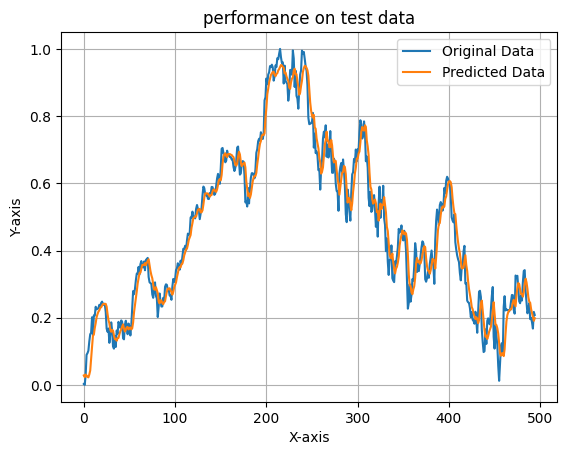

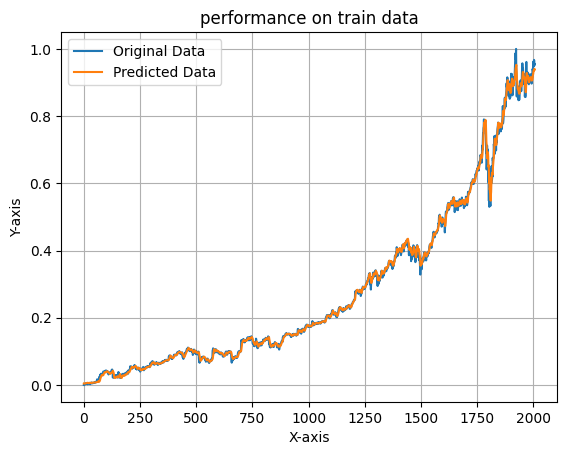

In [ ]:
test_predictions = get_predictions(model, X_test)
train_predictions = get_predictions(model, X_train)
plot_predictions(y_test, test_predictions, 'performance on test data')
plot_predictions(y_train, train_predictions, 'performance on train data')


In [ ]:
GWO_MSE = mean_squared_error(y_test, test_predictions)
GWO_MAE = mean_absolute_error(y_test, test_predictions)
GWO_RMSE = math.sqrt(GWO_MSE)
GWO_SMAPE = smape(y_test, test_predictions)
GWO_MSE_T = mean_squared_error(y_train, train_predictions)
GWO_MAE_T = mean_absolute_error(y_train, train_predictions)
GWO_RMSE_T = math.sqrt(GWO_MSE)
GWO_SMAPE_T = smape(y_train, train_predictions)
print('Training MAE - ', GWO_MAE)
print('Testing MAE - ', GWO_MAE_T)


Training MAE -  0.03706153528947683
Testing MAE -  0.006213519613343836


In [ ]:
# X = ['MSE','MAE','RMSE']
# LSTM = [LSTM_MSE,LSTM_MAE,LSTM_RMSE, LSTM_SMAPE]
# GWO = [GWO_MSE,GWO_MAE,GWO_RMSE, GWO_SMAPE]

# X_axis = np.arange(len(X))

# plt.bar(X_axis - 0.2, LSTM, 0.4, label = 'LSTM')
# plt.bar(X_axis + 0.2, GWO, 0.4, label = 'GWO-LSTM')

# plt.xticks(X_axis, X)
# plt.xlabel("Metrics")
# plt.ylabel("Values")
# plt.title("Comparison of Difference Metrics")
# plt.legend()
# plt.show()

from prettytable import PrettyTable
myTable = PrettyTable(["Model", "MSE", "MAE", "RMSE", "SMAPE"])

# Add rows
myTable.add_row(["Bi-LSTM", LSTM_MSE, LSTM_MAE, LSTM_RMSE, LSTM_SMAPE])
myTable.add_row(["Bi-LSTM-GWO", GWO_MSE,GWO_MAE,GWO_RMSE, GWO_SMAPE])

print('****************************Testing Performance Comparison*********************************')

print(myTable)

****************************Testing Performance Comparison*********************************
+-------------+-----------------------+----------------------+----------------------+--------------------+
|    Model    |          MSE          |         MAE          |         RMSE         |       SMAPE        |
+-------------+-----------------------+----------------------+----------------------+--------------------+
|   Bi-LSTM   |  0.00222533769913527  | 0.037059001273862247 | 0.047173485128144496 | 12.492153691985882 |
| Bi-LSTM-GWO | 0.0022123712893096035 | 0.03706153528947683  | 0.047035851106465625 | 12.552062041540125 |
+-------------+-----------------------+----------------------+----------------------+--------------------+


In [ ]:
myTable = PrettyTable(["Model", "MSE", "MAE", "RMSE", "SMAPE"])

# Add rows
myTable.add_row(["Bi-LSTM", LSTM_MSE_T, LSTM_MAE_T, LSTM_RMSE_T, LSTM_SMAPE_T])
myTable.add_row(["Bi-LSTM-GWO", GWO_MSE_T,GWO_MAE_T,GWO_RMSE_T, GWO_SMAPE_T])

print('****************************Training Performance Comparison*********************************')

print(myTable)

****************************Training Performance Comparison*********************************
+-------------+------------------------+----------------------+----------------------+--------------------+
|    Model    |          MSE           |         MAE          |         RMSE         |       SMAPE        |
+-------------+------------------------+----------------------+----------------------+--------------------+
|   Bi-LSTM   | 0.00012038275363086232 | 0.006672235445279217 | 0.047173485128144496 | 5.0060241076412835 |
| Bi-LSTM-GWO | 0.00011149375126807323 | 0.006213519613343836 | 0.047035851106465625 | 4.778609803084041  |
+-------------+------------------------+----------------------+----------------------+--------------------+
